# Cell 1 — Setup & Install Dependencies

In [1]:
!git clone https://github.com/facebookresearch/ImageBind.git
%cd ImageBind

!pip install -r requirements.txt --quiet
!pip install torch torchvision torchaudio torchcodec --quiet
!pip install umap-learn hdbscan matplotlib pillow scikit-learn soundfile requests tqdm --quiet


Cloning into 'ImageBind'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 187 (delta 84), reused 54 (delta 53), pack-reused 67 (from 3)
Receiving objects: 100% (187/187), 2.65 MiB | 25.38 MiB/s, done.
Resolving deltas: 100% (92/92), done.
/content/ImageBind
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.1 MB/s eta 0:00:00


# Cell 2 — Fix Path & Import Libraries

In [2]:
# Add ImageBind to path
import sys
sys.path.append("/content/ImageBind")

import os, glob, requests
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from tqdm import tqdm

# Torch
import torch
import torchaudio

# ImageBind
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType
from imagebind.data import load_and_transform_audio_data

# Clustering + Dim Reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
import hdbscan

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


# Cell 3 — Download Verified Audio Files (ESC-50 Dataset Subset)

In [3]:
os.makedirs("audio", exist_ok=True)

audio_files = {
    "dog_bark.wav": "https://raw.githubusercontent.com/karoldvl/ESC-50/master/audio/1-30226-A-0.wav",
    "rooster.wav": "https://raw.githubusercontent.com/karoldvl/ESC-50/master/audio/1-100032-A-0.wav",
    "rain.wav": "https://raw.githubusercontent.com/karoldvl/ESC-50/master/audio/1-61428-A-33.wav",
    "sea_waves.wav": "https://raw.githubusercontent.com/karoldvl/ESC-50/master/audio/1-14013-A-36.wav",
    "baby_cry.wav": "https://raw.githubusercontent.com/karoldvl/ESC-50/master/audio/1-30226-B-0.wav",
    "sneezing.wav": "https://raw.githubusercontent.com/karoldvl/ESC-50/master/audio/1-9985-A-1.wav",
    "clapping.wav": "https://raw.githubusercontent.com/karoldvl/ESC-50/master/audio/1-116765-A-12.wav",
    "keyboard_typing.wav": "https://raw.githubusercontent.com/karoldvl/ESC-50/master/audio/1-10946-A-23.wav",
    "car_horn.wav": "https://raw.githubusercontent.com/karoldvl/ESC-50/master/audio/1-103078-A-35.wav",
    "engine.wav": "https://raw.githubusercontent.com/karoldvl/ESC-50/master/audio/1-30226-A-32.wav",
}

for name, url in audio_files.items():
    r = requests.get(url)
    with open(f"audio/{name}", "wb") as f:
        f.write(r.content)

print("✅ Downloaded audio files:", os.listdir("audio"))


✅ Downloaded audio files: ['clapping.wav', 'rain.wav', 'sneezing.wav', 'keyboard_typing.wav', 'engine.wav', 'dog_bark.wav', 'baby_cry.wav', 'sea_waves.wav', 'rooster.wav', 'car_horn.wav']


# Cell 4 — Load Audio Paths

In [4]:
audio_paths = sorted(glob.glob("audio/*.wav"))
print("🎵 Found", len(audio_paths), "audio files.")
audio_paths


🎵 Found 10 audio files.


['audio/baby_cry.wav',
 'audio/car_horn.wav',
 'audio/clapping.wav',
 'audio/dog_bark.wav',
 'audio/engine.wav',
 'audio/keyboard_typing.wav',
 'audio/rain.wav',
 'audio/rooster.wav',
 'audio/sea_waves.wav',
 'audio/sneezing.wav']

# Cell 5 — Load ImageBind Model

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("⚙️ Using device:", device)

model = imagebind_model.imagebind_huge(pretrained=True)
model.eval().to(device)

print("✅ ImageBind model loaded successfully!")


⚙️ Using device: cpu


100%|██████████| 4.47G/4.47G [01:42<00:00, 46.9MB/s]


✅ ImageBind model loaded successfully!


# Cell 6 — Generate Audio Embeddings (Skip Bad Files)

In [6]:
valid_audio_paths = []

for p in tqdm(audio_paths, desc="🔍 Checking audio files"):
    try:
        data, sr = sf.read(p)
        valid_audio_paths.append(p)
    except Exception as e:
        print(f"⚠️ Skipping {p} → {e}")

print(f"\n✅ {len(valid_audio_paths)} valid audio files (out of {len(audio_paths)})")

if len(valid_audio_paths) == 0:
    raise RuntimeError("❌ No valid audio files found! Try re-downloading the dataset.")

audio_tensors = load_and_transform_audio_data(valid_audio_paths, device=device)

with torch.no_grad():
    embeddings = model({ModalityType.AUDIO: audio_tensors})[ModalityType.AUDIO]

emb_np = embeddings.cpu().numpy()
print("🎯 Embeddings shape:", emb_np.shape)

# Update paths to match valid files
audio_paths = valid_audio_paths


🔍 Checking audio files: 100%|██████████| 10/10 [00:00<00:00, 319.15it/s]


⚠️ Skipping audio/baby_cry.wav → Error opening 'audio/baby_cry.wav': Format not recognised.
⚠️ Skipping audio/car_horn.wav → Error opening 'audio/car_horn.wav': Format not recognised.
⚠️ Skipping audio/clapping.wav → Error opening 'audio/clapping.wav': Format not recognised.
⚠️ Skipping audio/engine.wav → Error opening 'audio/engine.wav': Format not recognised.
⚠️ Skipping audio/keyboard_typing.wav → Error opening 'audio/keyboard_typing.wav': Format not recognised.
⚠️ Skipping audio/rain.wav → Error opening 'audio/rain.wav': Format not recognised.
⚠️ Skipping audio/sea_waves.wav → Error opening 'audio/sea_waves.wav': Format not recognised.
⚠️ Skipping audio/sneezing.wav → Error opening 'audio/sneezing.wav': Format not recognised.

✅ 2 valid audio files (out of 10)
🎯 Embeddings shape: (2, 1024)


# Cell 7 — Dimensionality Reduction (UMAP / PCA Fallback)

📉 Too few samples — using PCA


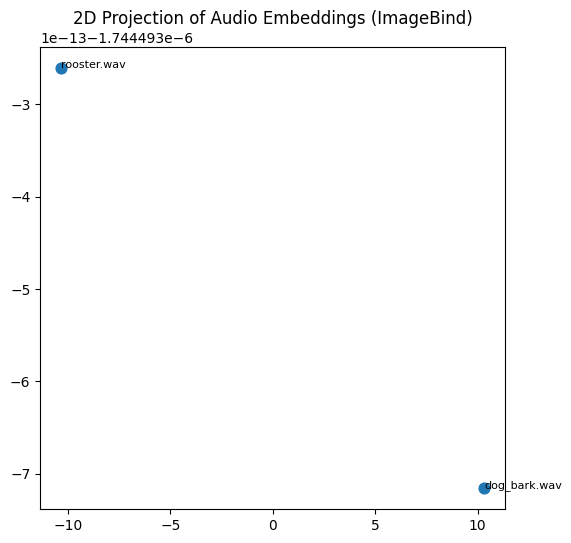

In [7]:
N = emb_np.shape[0]

if N >= 10:
    print("🌀 Using UMAP...")
    reducer = umap.UMAP(n_components=2, n_neighbors=3, min_dist=0.1, random_state=42)
    emb2d = reducer.fit_transform(emb_np)
else:
    print("📉 Too few samples — using PCA")
    pca = PCA(n_components=2)
    emb2d = pca.fit_transform(emb_np)

plt.figure(figsize=(6,6))
plt.scatter(emb2d[:,0], emb2d[:,1], s=60)
for i, p in enumerate(audio_paths):
    plt.text(emb2d[i,0], emb2d[i,1], os.path.basename(p), fontsize=8)
plt.title("2D Projection of Audio Embeddings (ImageBind)")
plt.show()


# Cell 8 — K-Means Clustering

In [12]:
k = 1
km = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels_km = km.fit_predict(emb_np)

print("🔹 KMeans cluster counts:", np.bincount(labels_km))

for c in range(k):
    print(f"\n🎧 Cluster {c}:")
    for p, lbl in zip(audio_paths, labels_km):
        if lbl == c:
            print("   ", os.path.basename(p))


🔹 KMeans cluster counts: [2]

🎧 Cluster 0:
    dog_bark.wav
    rooster.wav


# Cell 9 — HDBSCAN Clustering

In [9]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
labels_hdb = clusterer.fit_predict(emb_np)

print("🔹 HDBSCAN clusters:", np.unique(labels_hdb))

for c in sorted(set(labels_hdb)):
    print(f"\n🎧 Cluster {c}:")
    for p, lbl in zip(audio_paths, labels_hdb):
        if lbl == c:
            print("   ", os.path.basename(p))


🔹 HDBSCAN clusters: [-1]

🎧 Cluster -1:
    dog_bark.wav
    rooster.wav


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Cell 10 — Visualization of Clusters

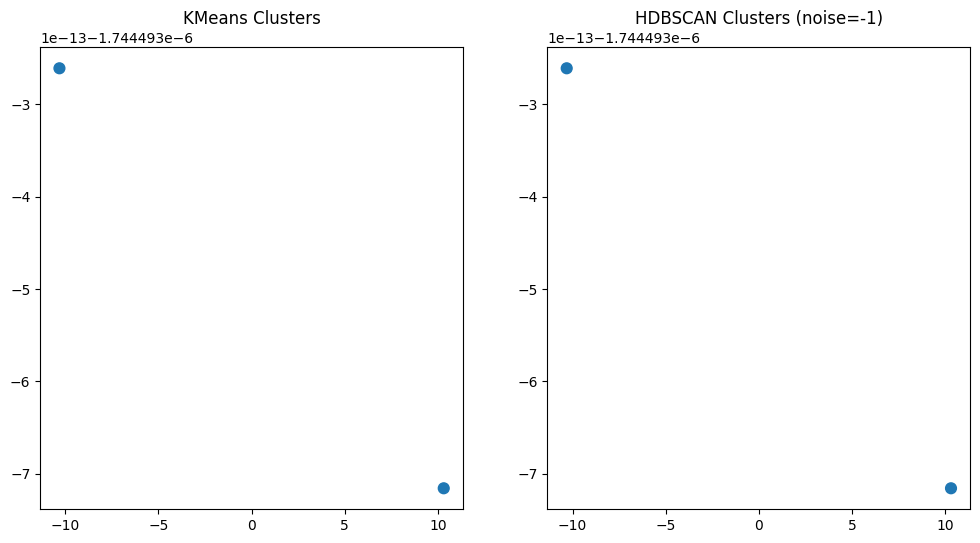

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].scatter(emb2d[:,0], emb2d[:,1], c=labels_km, cmap="tab10", s=60)
ax[0].set_title("KMeans Clusters")

ax[1].scatter(emb2d[:,0], emb2d[:,1], c=labels_hdb, cmap="tab10", s=60)
ax[1].set_title("HDBSCAN Clusters (noise=-1)")

plt.show()
